# NYC Real Data
In response to a reviewer, we are testing each inflation method on COVID data in Manhattan and comparing the fits of the estimated parameters derived from different methods.



In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

import glob
import os
import pickle
from tqdm import tqdm
import syslog

## Plot data from Teresa

To initialize our priors, we reference our group's operation model.

Notes on the ordering of boroughs:

    1831    {'Bronx County NY'   }    {'36005'}    {'36'}
    1859    {'New York County NY'}    {'36061'}    {'36'}
    1852    {'Kings County NY'   }    {'36047'}    {'36'}
    1869    {'Queens County NY'  }    {'36081'}    {'36'}
    1871    {'Richmond County NY'}    {'36085'}    {'36'}
    
There was a big reset national wide 12/5/21 for omicron where we basically dumped a bunch of recovered people back into S.

$D$ was varied over the ensemble but fixed over time.  Normally distributed, mean 3.5 days, std 0.15. We didn't change it for the different variants in this version on the model.

In [2]:
import scipy.io
mat = scipy.io.loadmat('fornickomicron.mat')

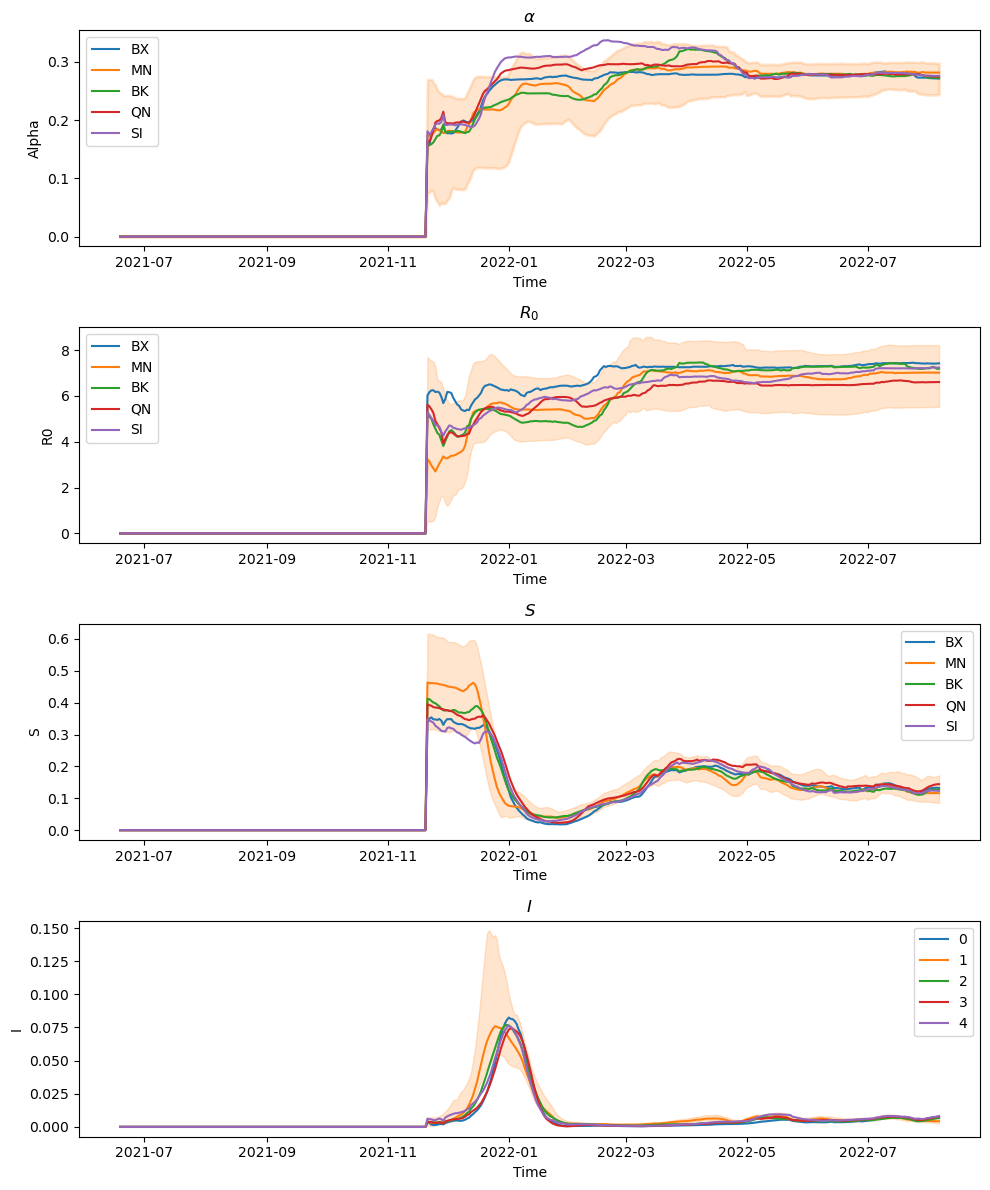

In [3]:
from matplotlib.dates import MonthLocator, DateFormatter

# Assuming 'mat' is a dictionary-like object containing the data

# Extract data
alpha_array = mat['trackalpha']
r0_array = mat['trackR0nyc']
S_array = mat['trackSnyc']
Ir_array = mat['trackIrnyc']
Itotal_array = mat['trackItotalnyc']

columns = ['BX', 'MN', 'BK', 'QN', 'SI']

# Create DataFrames
alpha_df = pd.DataFrame(alpha_array[:,1,:].T)
alpha_df.columns = columns

r0_df = pd.DataFrame(r0_array[:,1,:].T)
r0_df.columns = columns

S_df = pd.DataFrame(S_array[:,1,:].T)
S_df.columns = columns

I_df = pd.DataFrame(Itotal_array[:,1,:].T)
S_df.columns = columns

# Create a date range
date_range = pd.date_range(start='2021-06-19', end='2022-08-06')

# Set the index for the DataFrames
alpha_df.index = date_range
r0_df.index = date_range
S_df.index = date_range
I_df.index = date_range

# Create subplots
fig, axs = plt.subplots(4, 1, figsize=(10, 12))

# Plot alpha
axs[0].plot(alpha_df)
axs[0].legend(alpha_df.columns)
axs[0].set_title(r'$\alpha$')
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Alpha')

# Plot R0
axs[1].plot(r0_df)
axs[1].legend(r0_df.columns)
axs[1].set_title(r'$R_0$')
axs[1].set_xlabel('Time')
axs[1].set_ylabel('R0')

# Plot S
axs[2].plot(S_df)
axs[2].legend(S_df.columns)
axs[2].set_title(r'$S$')
axs[2].set_xlabel('Time')
axs[2].set_ylabel('S')

# Plot I
axs[3].plot(I_df)
axs[3].legend(I_df.columns)
axs[3].set_title(r'$I$')
axs[3].set_xlabel('Time')
axs[3].set_ylabel('I')

# Add shaded regions for 95% confidence intervals (assuming they are in indices 1 and 2)
for i in range(1, 2):
    
    # plot CI for alpha
    axs[0].fill_between(
        alpha_df.index, 
        alpha_array[i, 0, :],
        alpha_array[i, 2, :],
        alpha=0.2,
        linewidth=2,
        color=f'C{i}'
    )
    # plot CI for R0
    axs[1].fill_between(
        r0_df.index, 
        r0_array[i, 0, :],
        r0_array[i, 2, :],
        alpha=0.2,
        color=f'C{i}'
    )
    # plot CI for S
    axs[2].fill_between(
        S_df.index, 
        S_array[i, 0, :],
        S_array[i, 2, :],
        alpha=0.2,
        color=f'C{i}'
    )
    # plot CI for I
    axs[3].fill_between(
        I_df.index, 
        Itotal_array[i, 0, :],
        Itotal_array[i, 2, :],
        alpha=0.2,
        color=f'C{i}'
    )

# Adjust layout
plt.tight_layout()
plt.show()

# Set x-axis major ticks to every month
for ax in axs:
    ax.xaxis.set_major_locator(MonthLocator())
    ax.xaxis.set_major_formatter(DateFormatter('%Y-%m'))

# Add gridlines
for ax in axs:
    ax.grid(True)

plt.show()

In [4]:
alpha_df['2021-11-20':]

,BX,MN,BK,QN,SI
2021-11-20,0.000000,0.000000,0.000000,0.000000,0.000000
2021-11-21,0.161725,0.172850,0.159719,0.164457,0.180831
2021-11-22,0.156769,0.172959,0.157166,0.162677,0.175222
2021-11-23,0.177723,0.176118,0.158739,0.170925,0.179095
2021-11-24,0.185757,0.178128,0.161773,0.181867,0.184873
...,...,...,...,...,...
2022-08-02,0.271717,0.281443,0.272510,0.275145,0.276025
2022-08-03,0.271564,0.281376,0.272612,0.274911,0.275993
2022-08-04,0.271405,0.281328,0.272376,0.274547,0.275813
2022-08-05,0.271253,0.281420,0.272249,0.274398,0.275814


In [5]:
# use mean of ensemble median after stabilized for alpha
print(alpha_df['2022-03-01':].mean(axis=0))

alpha = alpha_df['2022-03-01':].mean(axis=0)['MN']

BX    0.277314
MN    0.283652
BK    0.286869
QN    0.283995
SI    0.292232
dtype: float64


In [6]:
# use ensemble median of at reset date for S
print(S_df['2021-12-05':'2021-12-05'])
S0 = S_df['2021-12-05':'2021-12-05']['MN']

S0_date = '2021-12-05'
row_idx = S_df.index.get_loc(S0_date)
print(S_array[1,:,row_idx])

S0_lower = S_array[1,0,row_idx]
S0_upper = S_array[1,2,row_idx]

                  BX       MN        BK        QN        SI
2021-12-05  0.336646  0.44721  0.376026  0.366395  0.312127
[0.31186025 0.44720972 0.58867278]


In [7]:
print(Itotal_array[1,:,row_idx])
I0_lower = Itotal_array[1,0,row_idx]
I0 = Itotal_array[1,1,row_idx]
I0_upper = Itotal_array[1,2,row_idx]

[0.00471758 0.00691678 0.02039702]


In [8]:
# check what to initialize $\beta to using $R_0$
import matplotlib.ticker as ticker

fig, ax = plt.subplots()


ax.plot(r0_df['2021-12-05':]['MN'], color='orange')
ax.fill_between(r0_df['2021-12-05':].index, r0_array[1, 0, 169:], r0_array[1, 2, 169:], alpha=0.2, color='orange')

plt.xticks(rotation=45) 

ax.grid()
ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.5))
ax.grid(which='minor', linestyle='--', alpha=0.5)

ax.set_title(r'$R_0$ in MN')

Text(0.5, 1.0, '$R_0$ in MN')

In [9]:
r0_date = '2022-01-01'
row_idx = r0_df.index.get_loc(r0_date)

print(fr'R_0 CI and median on {r0_date}: {r0_array[1, :, row_idx]}')

beta_low = r0_array[1, 0, row_idx] / 3.5
beta_high = r0_array[1, 2, row_idx] / 3.5

print('beta prior bounds:', beta_low.round(2), beta_high.round(2))
print('R0 prior bounds:', beta_low.round(2) * 3.5, beta_high.round(2) * 3.5)

R_0 CI and median on 2022-01-01: [4.35209645 5.57163998 7.08199342]
beta prior bounds: 1.24 2.02
R0 prior bounds: 4.34 7.07


## CDC Variant Proportion Tracker

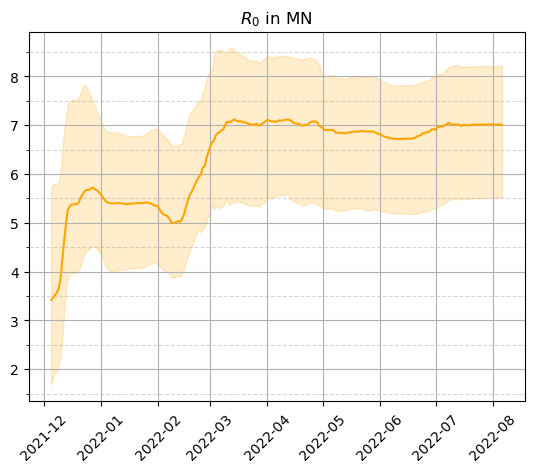

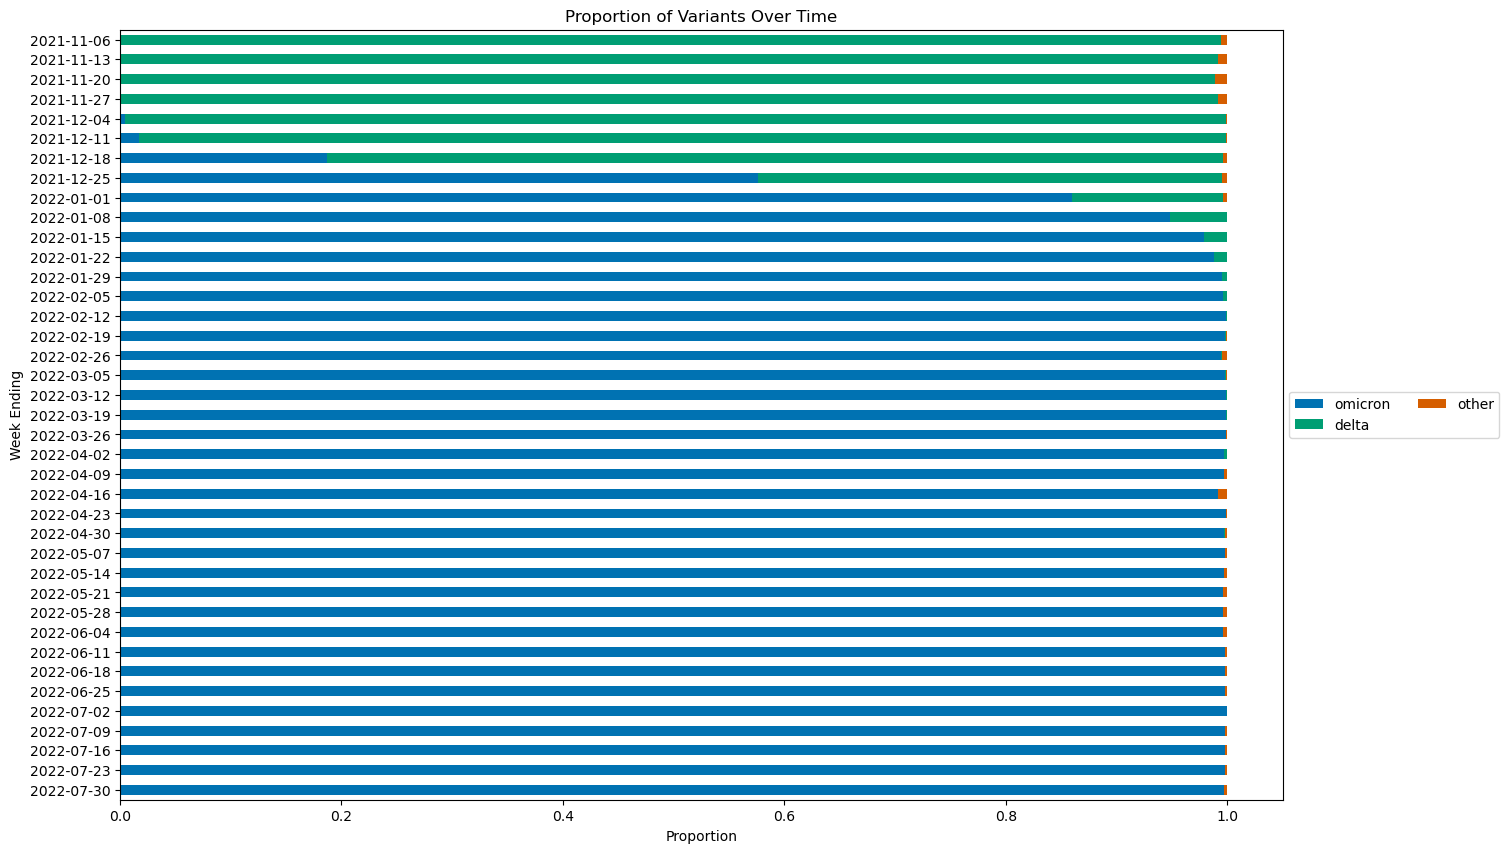

In [10]:
# CDC Variant Proportion Tracker
# https://covid.cdc.gov/covid-data-tracker/#variant-proportions

variant_data = pd.read_csv('SARS-CoV-2_Variant_Proportions_20250121.csv')

variant_data['week_ending'] = pd.to_datetime(variant_data['week_ending'])

variant_data_2021 = variant_data.loc[(variant_data['week_ending'] >  '2021-11-01') & (variant_data['week_ending'] < '2022-08-01')]
variant_data_2021 = variant_data_2021[variant_data_2021['time_interval'] == 'weekly']
variant_data_2021 = variant_data_2021.sort_values('published_date').drop_duplicates(subset=['week_ending', 'variant'], keep='last')
variant_data_2021_wide = variant_data_2021.loc[variant_data_2021['modeltype'] == 'weighted'].pivot(index='week_ending', columns='variant', values='share').fillna(0).reset_index()
variant_data_2021_wide.sort_values('week_ending', ascending=True, inplace=True)

# make sure each row sum to 1
variant_data_2021_wide['total_share'] = variant_data_2021_wide.drop(columns='week_ending').sum(axis=1)
variant_data_2021_wide.iloc[:, 1:-1] = variant_data_2021_wide.iloc[:, 1:-1].div(variant_data_2021_wide['total_share'], axis=0)
variant_data_2021_wide['total_share'] = variant_data_2021_wide.drop(columns=['week_ending','total_share']).sum(axis=1)

# categorize as delta (B.1.617.2), omicron (B.1.1.529), and other
variant_data_2021_wide.rename(columns={'B.1.617.2': 'delta'}, inplace=True)

variant_data_2021_wide['omicron'] = variant_data_2021_wide[['B.1.1.529', 'BA.1.1', 'BA.2', 'BA.2.12.1', 'BA.2.75', 'BA.2.75.2', 'BA.4', 'BA.4.6', 'BA.5', 'BA.5.2.6']].sum(axis=1)
variant_data_2021_wide.drop(columns=['B.1.1.529', 'BA.1.1', 'BA.2', 'BA.2.12.1', 'BA.2.75', 'BA.2.75.2', 'BA.4', 'BA.4.6', 'BA.5', 'BA.5.2.6'], inplace=True)

variant_data_2021_wide['other'] = variant_data_2021_wide.drop(columns=['week_ending', 'delta', 'omicron', 'total_share']).sum(axis=1)
variant_data_2021_wide = variant_data_2021_wide[['week_ending', 'delta', 'omicron', 'other']]

variant_data_2021_wide['week_ending'] = variant_data_2021_wide['week_ending'].dt.strftime('%Y-%m-%d')

plt.style.use('seaborn-v0_8-colorblind')

# Reorder the columns to show omicron first
variant_data_2021_wide = variant_data_2021_wide[['week_ending', 'omicron', 'delta', 'other']]

ax = variant_data_2021_wide.plot(
    x='week_ending',
    kind='barh',
    stacked=True,
    mark_right=True,
    figsize=(15, 10),
)

plt.legend(
    loc='center left',
    bbox_to_anchor=(1, 0.5),  # Place legend outside the plot
    ncol=2  # Number of columns in the legend
)
plt.gca().invert_yaxis()

plt.ylabel("Week Ending")
plt.xlabel("Proportion")
plt.title("Proportion of Variants Over Time")

plt.show()

## Empirical Data Plots

### Load JHU Case Data

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/955082041.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_long['Date'] = pd.to_datetime(df_long['Date'])


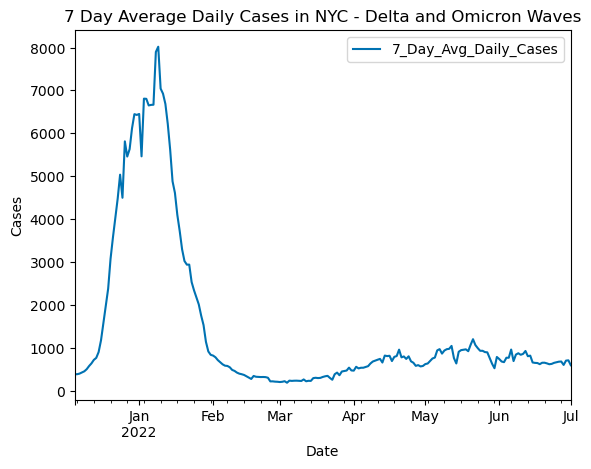

In [11]:
START_DATE = "12/05/2021"
END_DATE = "07/01/2022"
TIME_WINDOW_SIZE = 7
NYC_FIPS = 36061
RAW_CASE_URL = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/refs/heads/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv"

df = pd.read_csv(RAW_CASE_URL)
df = df.loc[df['FIPS'] == 36061]

df_long = pd.melt(df, id_vars=['UID', 'iso2', 'iso3', 'code3', 'FIPS', 'Admin2', 'Province_State', 'Country_Region', 'Lat', 'Long_', 'Combined_Key'], 
                  var_name='Date', value_name='Cases')
df_long['Date'] = pd.to_datetime(df_long['Date'])

# calculate daily cases and moving average
df_long['Daily_Cases'] = df_long.groupby('FIPS')['Cases'].diff().fillna(0)
df_long['7_Day_Avg_Daily_Cases'] = df_long['Daily_Cases'].rolling(window=7).mean()

# filter between START_DATE and END_DATE
df_long = df_long[(df_long['Date'] >= START_DATE) & (df_long['Date'] <= END_DATE)]
df_long.plot(x='Date', y='7_Day_Avg_Daily_Cases', title='7 Day Average Daily Cases in NYC - Delta and Omicron Waves', xlabel='Date', ylabel='Cases')
plt.show()


In [12]:
from epyfilter.simulate import simulate_data

# NYC population
N = 1.596*10**6

I0 = 2000
S0 = 0.33

true_params = {
    'rt_0': 1.3,
    'rt_1': 4.8, 
    'midpoint': 100,
    'k': 0.2,
    'n_t': df_long.shape[0],
    't_I': 3.50,
    'N': N,
    'S0': S0 * N,
    'I0': I0
}

np.random.seed(1994)

data = simulate_data.simulate_data(**true_params, add_noise=True, noise_param=1/50)
real_cases = df_long['7_Day_Avg_Daily_Cases'].values / alpha
data.i_true = real_cases
data.i = real_cases

In [13]:
alpha

np.float64(0.28365230839069)

### Run EAKF

#### Custom plotting for this notebook

In [43]:
import matplotlib.gridspec as gridspec
import matplotlib.lines as mlines

def plot_posterior(kf, title):
    fig = plt.figure(figsize=(16, 8))
    gs = fig.add_gridspec(4, 2)
    
    # plot R0
    ax_r0 = fig.add_subplot(gs[0:2, 0])
    ax_r0.plot([θ.beta * θ.t_I for θ in kf.θ_list], color="gray", alpha=0.1)
    ax_r0.plot(
        np.mean([θ.beta * θ.t_I for θ in kf.θ_list], axis=1), color="black")
    ax_r0.set_xlabel('day')
    ax_r0.set_ylabel(r'$R_0(t)$')

    # plot lambda and var
    ax_lam = fig.add_subplot(gs[2, 0])
    ax_lam.plot(np.linspace(0, kf.data.n_t, kf.data.n_t-1),
                np.append(np.ones(kf.data.n_t - len(kf.lam_list) - 1),
                            kf.lam_list))
    ax_lam.set_xlabel("day")
    ax_lam.set_ylabel(r"$\lambda$")
    
    ax_var = fig.add_subplot(gs[3, 0])
    ax_var.plot(np.concatenate(
        (np.zeros(kf.data.n_t - len(kf.lam_var_list)-1),
            kf.lam_var_list)))
    ax_var.set_xlabel("day")
    ax_var.set_ylabel(r"$\sigma^2_{\lambda}$")
    
    # plot SIR
    ax_sir = fig.add_subplot(gs[0:2, 1])
    ax_sir.plot([x.S/true_params["N"] for x in kf.x_list], color='orange', alpha=0.01)
    ax_sir.plot(np.mean([x.S/true_params["N"] for x in kf.x_list], axis=1), color='orange', label="S")

    ax_sir.plot([x.I/true_params["N"] for x in kf.x_list], color='firebrick', alpha=0.01)
    ax_sir.plot(np.mean([x.I/true_params["N"] for x in kf.x_list], axis=1), color='firebrick', label="I")

    ax_sir.plot([x.R/true_params["N"] for x in kf.x_list], color='dodgerblue', alpha=0.01)
    ax_sir.plot(np.mean([x.R/true_params["N"] for x in kf.x_list], axis=1), color='dodgerblue', label="R")
    ax_sir.legend()
    
    # plot i
    ax_i = fig.add_subplot(gs[2:, 1])
    ax_i.plot(kf.data.i, '.')
    ax_i.plot([x.i for x in kf.x_list], color='gray', alpha=0.1)
    ax_i.plot(np.mean([x.i for x in kf.x_list], axis=1), color='black')
    ax_i.set_ylabel('daily case counts')
    
    fig.suptitle(f'{title}')

# plot ppd
def plot_ppd(title=None):
    dates = df_long['Date']
    truth = data.i

    fig = plt.figure(figsize=(7.5*2, 8.75*1.25))

    gs = gridspec.GridSpec(3, 3, height_ratios=[1, 1, 1], width_ratios=[1, 1, 1])

    # no inflation
    ax1 = plt.subplot(gs[0,0])
    ax1.plot(dates, kf_none.i_ppc[1:], color="dodgerblue", alpha=0.02)
    ax1.plot(dates, np.mean(kf_none.i_ppc[1:], axis=1), color='blue')
    ax1.plot(dates, truth, "x", color='firebrick', markersize=2)

    # fixed inflation
    ax2 = plt.subplot(gs[1,0], sharey=ax1)
    ax2.plot(dates, kf_fixed.i_ppc[1:], color="purple", alpha=0.02)
    ax2.plot(dates, np.mean(kf_fixed.i_ppc[1:], axis=1), color='purple')
    ax2.plot(dates, truth, "x", color='firebrick', markersize=2)

    # adaptive inflation
    ax3 = plt.subplot(gs[0,1], sharey=ax1)
    ax3.plot(dates, kf.i_ppc[1:], color="goldenrod", alpha=0.02)
    ax3.plot(dates, np.mean(kf.i_ppc[1:], axis=1), color='orange')
    ax3.plot(dates, truth, "x", color='firebrick', markersize=2)

    # ensrs
    ax4 = plt.subplot(gs[1,1], sharey=ax1)
    ax4.plot(dates[:-9], ks.i_ppc[1:], color="seagreen", alpha=0.02)
    ax4.plot(dates[:-9], np.mean(ks.i_ppc[1:], axis=1), color='mediumseagreen')
    ax4.plot(dates, truth, "x", color='firebrick', markersize=2)

    # epiestim
    ax5 = plt.subplot(gs[2,0], sharey=ax1)
    ax5.plot(dates.iloc[epiestim_ppc_df['day']], epiestim_ppc_df['sample' + np.arange(1, 301).astype(str)], color="gray", alpha=0.01)
    ax5.plot(dates.iloc[epiestim_ppc_df['day']], np.mean(epiestim_ppc_df['sample' + np.arange(1, 301).astype(str)], axis=1), color="black")
    ax5.plot(dates, truth, "x", color='firebrick', markersize=2)


    # reliability
    ax6 = plt.subplot(gs[:,2])
    ax6.plot(percentiles / 100, kf_none.prop_list, ".-", color='dodgerblue')
    ax6.plot(percentiles / 100, kf_fixed.prop_list, ".-", color='purple')
    ax6.plot(percentiles / 100, kf.prop_list, ".-", color='goldenrod')
    ax6.plot(percentiles / 100, ks.prop_list, ".-", color='seagreen')
    ax6.plot(percentiles / 100, epiestim_reliability, ".-", color='black')
    ax6.plot([0, 1], [0, 1], '--', color="k", label="Perfect coverage")

    # # reliability no noise

    # def compute_reliability(kk, percentiles):
    #     prop_list = []
    #     for p in percentiles:
    #         lower = np.quantile(
    #             kk.i_ppc_true, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0, :]
    #         upper = np.quantile(
    #             kk.i_ppc_true, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1, :]

    #         if len(kk.i_ppc) < len(kk.data.i) + 1:
    #             pp = (lower <= kk.data.i[:len(kk.i_ppc)]) & (kk.data.i[:len(kk.i_ppc)] <= upper)
    #             prop_list.append(np.mean(pp[np.where(kk.data.i[:len(kk.i_ppc)] > 5)]))
    #         else:
    #             pp = (lower[1:] <= kk.data.i) & (kk.data.i <= upper[1:])
    #             prop_list.append(np.mean(pp[np.where(kk.data.i > 5)]))
    #     return prop_list

    # ax5.plot(percentiles / 100, compute_reliability(kf_none, percentiles), "--", label = 'EAKF with no inflation (no OEV noise)', color='dodgerblue')
    # ax5.plot(percentiles / 100, compute_reliability(kf_fixed, percentiles), "--", label='EAKF with fixed inflation (no OEV noise)', color='purple')
    # ax5.plot(percentiles / 100, compute_reliability(kf, percentiles), "--", label='EAKF with adaptive inflation (no OEV noise)', color='goldenrod')
    # ax5.plot(percentiles / 100, compute_reliability(ks, percentiles), "--", label='EnSRS (smoothing) with adaptive inflation (no OEV noise)', color='seagreen')

    ax6.set_title("Reliability")
    ax6.set_ylabel("Coverage")
    ax6.set_xlabel("Quantile")
    ax6.legend()

    ax6.yaxis.set_minor_locator(ticker.MultipleLocator(0.05))
    ax6.grid(which='minor', linestyle='--', alpha=0.5)
    ax6.grid(linestyle='dotted')

    for ax in [ax1, ax2, ax3, ax4, ax5]:
        ax.grid(linestyle='dotted')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_facecolor('aliceblue')

    plt.subplots_adjust(hspace = 0.5, wspace=0.3)
    fig.text(0, 0.5, 'daily case counts', va='center', rotation='vertical')
    fig.text(0.5, 0.01, 'day', ha='center')
    if title:
        fig.suptitle(title, fontsize=12)
    else:
        fig.suptitle('Posterior predictive distributions', fontsize=12)

    # add legend
    red_line = mlines.Line2D([], [], color='firebrick', marker='x', linestyle='None', markersize=2) 
    blue_line = mlines.Line2D([], [], color='dodgerblue', linestyle='-')
    purple_line = mlines.Line2D([], [], color='purple', linestyle='-')
    orange_line = mlines.Line2D([], [], color='goldenrod', linestyle='-')
    green_line = mlines.Line2D([], [], color='seagreen', linestyle='-')
    black_line = mlines.Line2D([], [], color='gray', linestyle='-')

    handles = [red_line, blue_line, purple_line, orange_line, green_line, black_line]
    labels = ['Data distribution', 'EAKF with no inflation', 'EAKF with fixed inflation', 'EAKF with adaptive inflation', 'EnSRS (smoothing) with adaptive inflation', 'EpiEstim']
    fig.legend(handles, labels, loc='upper left')

    plt.tight_layout()
    fig.savefig('real_data_eakf_ppd.png')
    fig.savefig(f"real_data_eakf_ppd.eps", format='eps', bbox_inches='tight', transparent=True)
    fig.savefig(f"real_data_eakf_ppd.pdf", bbox_inches='tight', transparent=True)

#### Custom Predictive Posterior 

Instead of computing the PPC with $R_0$ we compute it with $R_e$

Instead of computing the reliability for the entire time series, we only compute the reliability for the second epidemic wave(s) after the first epidemic.

In [15]:
def free_sim_re(kk, add_noise=False, burn_in_days=22):
    S = np.array([kk.data.S0 * np.ones(kk.m)])
    Ir = np.array([kk.data.I0 * np.ones(kk.m)])
    i = np.array([np.zeros(kk.m)])

    susc = np.array([x.S for x in kk.x_list])
    r0 = np.array([θ.beta * θ.t_I for θ in kk.θ_list])
    re = r0 * susc / kk.data.N

    for t in range(kk.data.beta.shape[0]):
        if t < burn_in_days:
            dSI = np.random.poisson(re[burn_in_days]/kk.data.t_I * Ir[t])
        else:
            dSI = np.random.poisson(re[t]/kk.data.t_I * Ir[t])
        dIR = np.random.poisson(Ir[t]/kk.data.t_I)

        S_new = np.clip(S[t]-dSI, 0, kk.data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, kk.data.N)

        S = np.append(S, [S_new], axis=0)
        Ir = np.append(Ir, [I_new], axis=0)
        i = np.append(i, [dSI], axis=0)
    
    kk.i_ppc_true = i
    if add_noise:
        i = i.astype("float64")
        obs_error_var = np.maximum(1.0, i[1:] ** 2 * kk.data.noise_param)
        obs_error_sample = np.random.normal(0, 1, size=(kk.data.n_t, kk.m))
        i[1:] += obs_error_sample * np.sqrt(obs_error_var)
        i = np.clip(i, 0,kk.data.N)

    kk.i_ppc = i

    return S, Ir, i

def free_sim_re_ks(kk, add_noise=False, burn_in_days=22):
    S = np.array([kk.data.S0 * np.ones(kk.eakf.m)])
    Ir = np.array([kk.data.I0 * np.ones(kk.eakf.m)])
    i = np.array([np.zeros(kk.eakf.m)])

    susc = np.array([x.S for x in kk.x_list])
    r0 = np.array([θ.beta * θ.t_I for θ in kk.θ_list])
    re = r0 * susc / kk.data.N

    for t in range(len(kk.θ_lag_list)):
        if t < burn_in_days:
            dSI = np.random.poisson(re[burn_in_days]/kk.data.t_I * Ir[t])
        else:
            dSI = np.random.poisson(re[t]/kk.data.t_I * Ir[t])
        dIR = np.random.poisson(Ir[t]/kk.data.t_I)

        S_new = np.clip(S[t]-dSI, 0, kk.data.N)
        I_new = np.clip(Ir[t]+dSI-dIR, 0, kk.data.N)

        S = np.append(S, [S_new], axis=0)
        Ir = np.append(Ir, [I_new], axis=0)
        i = np.append(i, [dSI], axis=0)
    
    kk.i_ppc_true = i
    if add_noise:
        i = i.astype("float64")
        obs_error_var = np.maximum(1.0, i[1:] ** 2 * kk.data.noise_param)
        obs_error_sample = np.random.normal(0, 1, size=(len(kk.x_list), kk.eakf.m))
        i[1:] += obs_error_sample * np.sqrt(obs_error_var)
        i = np.clip(i, 0,kk.data.N)

    kk.i_ppc = i

    return S, Ir, i

In [16]:
march_idx = np.where(df_long.Date > '2022-03-01')[0][0]

# def compute_reliability(kk, percentiles):
#     prop_list = []
#     betas = np.asarray([θ.beta for θ in kk.θ_list])
#     if not hasattr(kk, "i_ppc"):
#         kk.free_sim(betas)
#     for p in percentiles:
#         lower = np.quantile(
#             kk.i_ppc, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0, :]
#         upper = np.quantile(
#             kk.i_ppc, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1, :]
#         pp = (lower[march_idx+1:] <= kk.data.i[march_idx:]) & (kk.data.i[march_idx:] <= upper[march_idx+1:])
#         prop_list.append(np.mean(pp[np.where(kk.data.i[march_idx:] > 5)]))

#     kk.prop_list = prop_list

# def compute_reliability_ks(kk, percentiles):
#     prop_list = []
#     betas = np.asarray([θ.beta for θ in kk.θ_list])
#     if not hasattr(kk, 'i_ppc'):
#         kk.free_sim(betas)
#     for p in percentiles:
#         lower = np.quantile(
#             kk.i_ppc, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0, :]
#         upper = np.quantile(
#             kk.i_ppc, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1, :]
#         pp = (lower[march_idx:] <= kk.data.i[march_idx:len(kk.i_ppc)]) & (kk.data.i[march_idx:len(kk.i_ppc)] <= upper[march_idx:])
#         prop_list.append(np.mean(pp[np.where(kk.data.i[march_idx:len(kk.i_ppc)] > 5)]))
#     kk.prop_list = prop_list

def compute_reliability_epiestim(epiestim_ppc_df, percentiles):
    prop_list = []

    epiestim_ppc_array = np.array(epiestim_ppc_df["sample"+np.arange(1, 301).astype(str)].iloc[1:])
    for p in percentiles:
        lower = np.quantile(
            epiestim_ppc_array, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[0, :]
        upper = np.quantile(
            epiestim_ppc_array, q=[(1-p/100)/2, 1-(1-p/100)/2], axis=1)[1, :]
        
        pp = (lower <= kf.data.i[:len(epiestim_ppc_array)]) & (kf.data.i[:len(epiestim_ppc_array)] <= upper)
        prop_list.append(np.mean(pp[np.where(kf.data.i[:len(epiestim_ppc_array)] > 5)]))
        # after march 1
        # pp = (lower[march_idx:] <= kf.data.i[march_idx:len(epiestim_ppc_array)]) & (kf.data.i[march_idx:len(epiestim_ppc_array)] <= upper[march_idx:])
        # prop_list.append(np.mean(pp[np.where(kf.data.i[march_idx:len(epiestim_ppc_array)] > 5)]))


    return prop_list



In [58]:
from numpy.random import uniform
from epyfilter.eakf import model_da, eakf, enks
from matplotlib.backends.backend_pdf import PdfPages


# plot with different starting dates for beta in ippc
with PdfPages('posterior_plots6.pdf') as pdf:
    # for r0_mean in tqdm(np.arange(1,3.25,0.25)):
    #     for days in tqdm(np.arange(1,23,1)):
    for r0_mean, days in zip([2.], [14]):
        print(r0_mean, days)
        b_low = (r0_mean - 1)/ 3.5
        b_high = (r0_mean + 1) / 3.5
        prior = {
                    "beta": {
                        "dist": uniform,
                        "args": {
                            "low": b_low,
                            "high": b_high,
                            # "low": 0.2,
                            # "high": 1.7,
                        },
                    },
                    "t_I": {
                        "dist": "constant",
                    }
                }

        n_ens = 300
        model = model_da.SIR_model(data)


        # adaptive
        kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
        kf.filter(prior, inf_method="adaptive")

        # ensrs
        ks = enks.EnsembleSquareRootSmoother(kf)
        ks.smooth(window_size=10, plot=False)

        # no inflation
        kf_none = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
        kf_none.filter(prior, inf_method="none")

        # fixed inflation
        kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
        kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.05)


        plot_re_posterior()
        pdf.savefig()
        plt.close()
        
        # compute ppd
        # kf.free_sim(np.asarray([θ.beta for θ in kf.θ_list]), add_noise=True)
        # ks.free_sim(np.asarray([θ.beta for θ in ks.θ_lag_list]), add_noise=True)
        # kf_none.free_sim(np.asarray([θ.beta for θ in kf_none.θ_list]), add_noise=True)
        # kf_fixed.free_sim(np.asarray([θ.beta for θ in kf_fixed.θ_list]), add_noise=True)

        free_sim_re(kf, add_noise=True, burn_in_days=days)
        free_sim_re_ks(ks, add_noise=True, burn_in_days=days)
        free_sim_re(kf_none, add_noise=True, burn_in_days=days)
        free_sim_re(kf_fixed, add_noise=True, burn_in_days=days)
        print(np.max(kf.i_ppc))
        # compute reliabilty
        percentiles = np.arange(2.5, 100, 2.5)
        # compute_reliability(kf, percentiles)
        # compute_reliability_ks(ks, percentiles)
        # compute_reliability(kf_none, percentiles)
        # compute_reliability(kf_fixed, percentiles)

        kf.compute_reliability(percentiles)
        ks.compute_reliability(percentiles)
        kf_none.compute_reliability(percentiles)
        kf_fixed.compute_reliability(percentiles)

        print(np.max(kf.i_ppc))
        plot_ppd(f'Posterior predictive distributions')
        pdf.savefig()
        plt.close()

2.0 14


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2127492994.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


70272.85777946832
70272.85777946832


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/785913295.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/785913295.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/785913295.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/785913295.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a Fi

In [25]:
from numpy.random import uniform
from epyfilter.eakf import model_da, eakf, enks

r0_mean = 2.0
burn_in = 14

b_low = (r0_mean - 1)/ 3.5
b_high = (r0_mean + 1) / 3.5
prior = {
            "beta": {
                "dist": uniform,
                "args": {
                    "low": b_low,
                    "high": b_high,
                    # "low": 0.2,
                    # "high": 1.7,
                },
            },
            "t_I": {
                "dist": "constant",
            }
        }

state_prior = {
    "S" : {
        "dist": uniform,
        "args": {
            "low": S0_lower,
            "high": S0_upper,
        }
    },
    "I" : {
        "dist": uniform,
        "args": {
            "low": I0_lower,
            "high": I0_upper,
        }
    }
}



n_ens = 300
model = model_da.SIR_model(data)
# model = model_da.SIR_model(data, state_prior)


# adaptive
kf = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
kf.filter(prior, inf_method="adaptive")

# ensrs
ks = enks.EnsembleSquareRootSmoother(kf)
ks.smooth(window_size=10, plot=False)

# no inflation
kf_none = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
kf_none.filter(prior, inf_method="none")

# fixed inflation
kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
kf_fixed.filter(prior, inf_method="constant", lam_fixed=1.05)

In [26]:
def load_epiestim_post(path="nyc_real_data_epiestim_posterior.csv"):
    epiestim_df = pd.read_csv(path)
    return epiestim_df

epiestim_df = load_epiestim_post()

# load epiestim ppd
percentiles = np.arange(2.5, 100, 2.5)

epiestim_ppc_df = pd.read_csv("nyc_real_data_epiestim_ippc.csv")

epiestim_reliability = compute_reliability_epiestim(epiestim_ppc_df, percentiles)

In [27]:
# compute ppd using Re
# kf.free_sim(np.asarray([θ.beta for θ in kf.θ_list]), add_noise=True)
# ks.free_sim(np.asarray([θ.beta for θ in ks.θ_lag_list]), add_noise=True)
# kf_none.free_sim(np.asarray([θ.beta for θ in kf_none.θ_list]), add_noise=True)
# kf_fixed.free_sim(np.asarray([θ.beta for θ in kf_fixed.θ_list]), add_noise=True)
free_sim_re(kf, add_noise=True, burn_in_days=burn_in)
free_sim_re_ks(ks, add_noise=True, burn_in_days=burn_in)
free_sim_re(kf_none, add_noise=True, burn_in_days=burn_in)
free_sim_re(kf_fixed, add_noise=True, burn_in_days=burn_in)

percentiles = np.arange(2.5, 100, 2.5)
kf.compute_reliability(percentiles)
ks.compute_reliability(percentiles)
kf_none.compute_reliability(percentiles)
kf_fixed.compute_reliability(percentiles)

epiestim_reliability = compute_reliability_epiestim(epiestim_ppc_df, percentiles)

# compute reliabilty after March
# compute_reliability(kf, percentiles)
# compute_reliability_ks(ks, percentiles)
# compute_reliability(kf_none, percentiles)
# compute_reliability(kf_fixed, percentiles)


/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2779187793.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


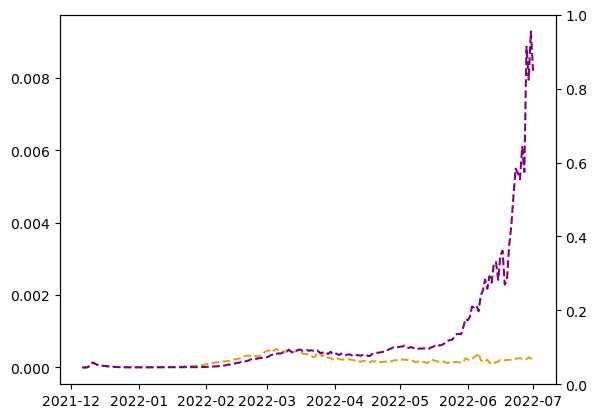

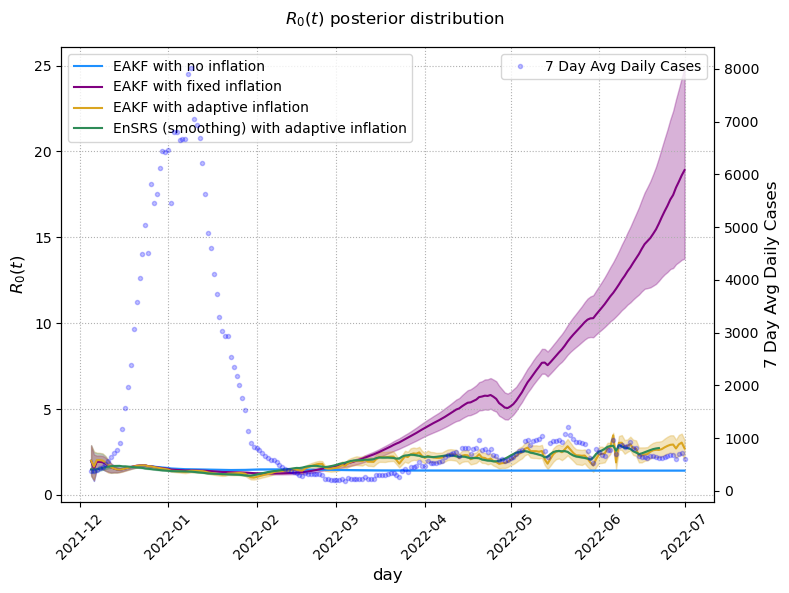

In [34]:
def compute_ci_mean(kf, smooth=False, confidence_level=95):
    if smooth:
         array = np.array([θ.beta*θ.t_I for θ in kf.θ_lag_list])
    else:
        array = np.array([θ.beta * θ.t_I for θ in kf.θ_list])
    ci = np.percentile(array, [100 - confidence_level, confidence_level], axis=1)
    mean = np.mean(array, axis=1)
    return ci, mean


# compute mean and cis
ci_no, mean_no = compute_ci_mean(kf_none)
ci_fixed, mean_fixed = compute_ci_mean(kf_fixed)
ci_adapt, mean_adapt = compute_ci_mean(kf)
ci_smooth, mean_smooth = compute_ci_mean(ks, smooth=True)

fig, ax = plt.subplots()
fig.suptitle(r"$R_0(t)$ posterior distribution")
fig.set_figheight(6)
fig.set_figwidth(8)

ax.fill_between(df_long['Date'], ci_no[0,:], ci_no[1,:], color='dodgerblue', alpha=0.3)
ax.plot(df_long['Date'], mean_no, color="dodgerblue", label=r"EAKF with no inflation")

ax.fill_between(df_long['Date'], ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
ax.plot(df_long['Date'], mean_fixed, color="purple", label=r"EAKF with fixed inflation")

ax.fill_between(df_long['Date'], ci_adapt[0,:], ci_adapt[1,:], color='goldenrod', alpha=0.3)
ax.plot(df_long['Date'], mean_adapt, color="goldenrod", label=r"EAKF with adaptive inflation")

ax.fill_between(df_long['Date'][:-9], ci_smooth[0,:], ci_smooth[1,:], color='seagreen', alpha=0.3)
ax.plot(df_long['Date'][:-9], mean_smooth, color="seagreen", label=r"EnSRS (smoothing) with adaptive inflation")

# plot cases in background
ax2 = ax.twinx()
ax2.plot(df_long['Date'], df_long['7_Day_Avg_Daily_Cases'], '.', alpha=0.25, color='blue', label='7 Day Avg Daily Cases')
ax2.set_ylabel('7 Day Avg Daily Cases', fontsize=12)
ax2.legend(loc='upper right')

ax.set_xlabel("day", fontsize=12)
ax.set_ylabel(r"$R_0(t)$", fontsize=12)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

ax.legend(loc='upper left')
ax.grid(linestyle='dotted')
fig.tight_layout()
fig.savefig('real_data_eakf_posterior.png')
fig.savefig(f"real_data_eakf_posterior.eps", format='eps', bbox_inches='tight', transparent=True)
fig.savefig(f"real_data_eakf_posterior.pdf", bbox_inches='tight', transparent=True)

plt.show()

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2127492994.py:50: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


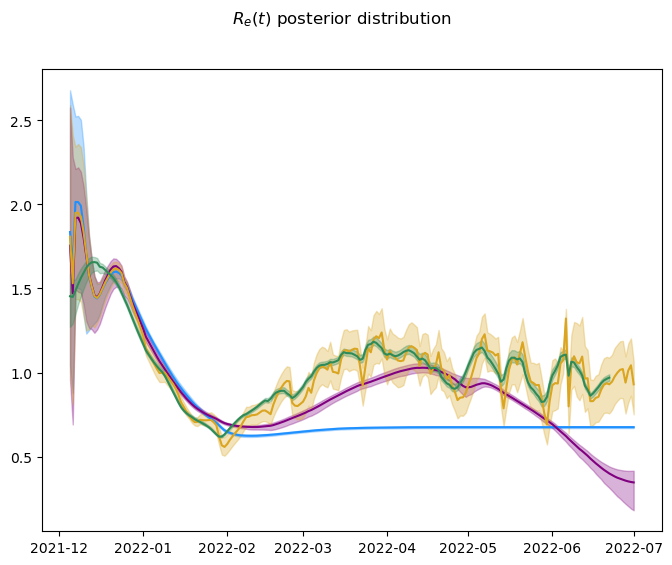

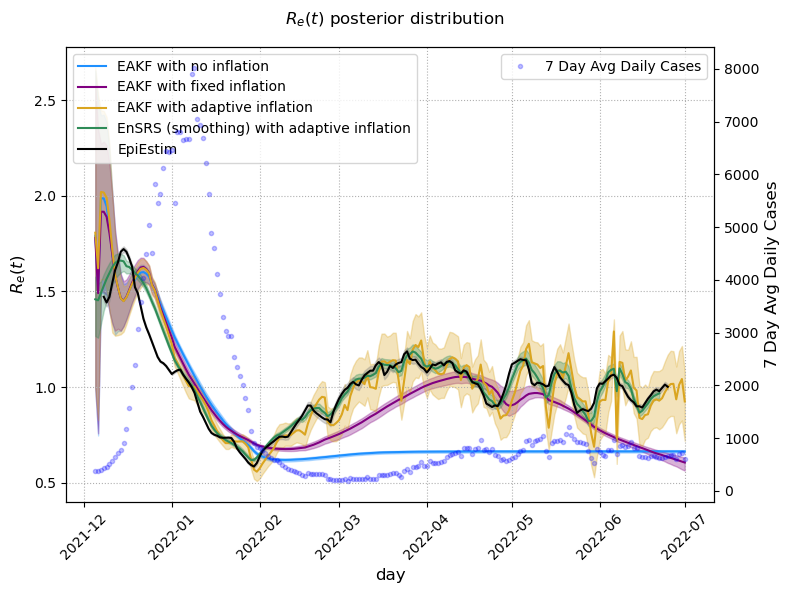

In [30]:
def compute_re_ci_mean(kf, smooth=False, confidence_level=95):
    if smooth:
        susc = np.array([x.S for x in kf.x_list])
        array = np.array([θ.beta*θ.t_I for θ in kf.θ_lag_list])
        array = array * susc / kf.eakf.data.N
    else:
        susc = np.array([x.S for x in kf.x_list])
        array = np.array([θ.beta * θ.t_I for θ in kf.θ_list])
        array = array * susc / kf.data.N
    ci = np.percentile(array, [100 - confidence_level, confidence_level], axis=1)
    mean = np.mean(array, axis=1)
    return ci, mean

def plot_re_posterior():
    # compute mean and cis
    ci_no, mean_no = compute_re_ci_mean(kf_none)
    ci_fixed, mean_fixed = compute_re_ci_mean(kf_fixed)
    ci_adapt, mean_adapt = compute_re_ci_mean(kf)
    ci_smooth, mean_smooth = compute_re_ci_mean(ks, smooth=True)

    fig, ax = plt.subplots()
    fig.suptitle(r"$R_e(t)$ posterior distribution")
    fig.set_figheight(6)
    fig.set_figwidth(8)

    ax.fill_between(df_long['Date'], ci_no[0,:], ci_no[1,:], color='dodgerblue', alpha=0.3)
    ax.plot(df_long['Date'], mean_no, color="dodgerblue", label=r"EAKF with no inflation")

    ax.fill_between(df_long['Date'], ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
    ax.plot(df_long['Date'], mean_fixed, color="purple", label=r"EAKF with fixed inflation")

    ax.fill_between(df_long['Date'], ci_adapt[0,:], ci_adapt[1,:], color='goldenrod', alpha=0.3)
    ax.plot(df_long['Date'], mean_adapt, color="goldenrod", label=r"EAKF with adaptive inflation")

    ax.fill_between(df_long['Date'][:-9], ci_smooth[0,:], ci_smooth[1,:], color='seagreen', alpha=0.3)
    ax.plot(df_long['Date'][:-9], mean_smooth, color="seagreen", label=r"EnSRS (smoothing) with adaptive inflation")

    ax.fill_between(df_long['Date'].iloc[3:203], epiestim_df['Quantile.0.025(R)'], epiestim_df['Quantile.0.975(R)'], color='grey', alpha=0.3)
    ax.plot(df_long['Date'].iloc[3:203], epiestim_df['Mean(R)'], color='black', label=r"EpiEstim")

    # plot cases in background
    ax2 = ax.twinx()
    ax2.plot(df_long['Date'], df_long['7_Day_Avg_Daily_Cases'], '.', alpha=0.25, color='blue', label='7 Day Avg Daily Cases')
    ax2.set_ylabel('7 Day Avg Daily Cases', fontsize=12)
    ax2.legend(loc='upper right')


    ax.set_xlabel("day", fontsize=12)
    ax.set_ylabel(r"$R_e(t)$", fontsize=12)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

    ax.legend(loc='upper left')
    ax.grid(linestyle='dotted')
    fig.tight_layout()
    fig.savefig('real_data_eakf_posterior2.png')
    fig.savefig(f"real_data_eakf_posterior2.eps", format='eps', bbox_inches='tight', transparent=True)
    fig.savefig(f"real_data_eakf_posterior2.pdf", bbox_inches='tight', transparent=True)

plot_re_posterior()
plt.show()

#### Figure out why fixed inflation is crazy

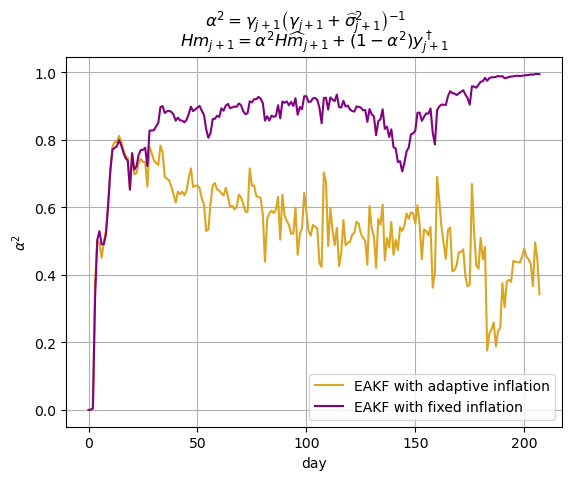

In [31]:
# plot the kalman gain (alpha)

fig, ax = plt.subplots()

ax.plot(kf.alpha_list[:,0]**2, color="goldenrod", label=r"EAKF with adaptive inflation")
ax.plot(kf_fixed.alpha_list[:,0]**2, color="purple", label=r"EAKF with fixed inflation")

ax.set_ylabel(r"$\alpha^2$")
ax.set_xlabel("day")
ax.legend()
ax.set_title(r"$Hm_{j+1} = \alpha^2 H \widehat{m}_{j+1} + (1 - \alpha^2) y_{j+1}^\dagger$")
plt.suptitle(r"$\alpha^2 = \gamma_{j+1}\left(\gamma_{j+1}+ \widehat{\sigma}_{j+1}^2 \right)^{-1}$")
ax.grid("dotted")

plt.show()  

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2046716541.py:6: RuntimeWarning: invalid value encountered in scalar divide
  ols = [np.cov(i_prior[j], beta_prior[j])[0,1] / np.cov(i_prior[j], beta_prior[j])[0,0] for j in range(i_prior.shape[0])]
/opt/anaconda3/envs/epyfilter/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3045: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/envs/epyfilter/lib/python3.13/site-packages/numpy/lib/_function_base_impl.py:3046: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2046716541.py:16: RuntimeWarning: invalid value encountered in scalar divide
  adapt_ols = [np.cov(i_prior[j], beta_prior[j])[0,1] / np.cov(i_prior[j], beta_prior[j])[0,0] for j in range(i_prior.shape[0])]


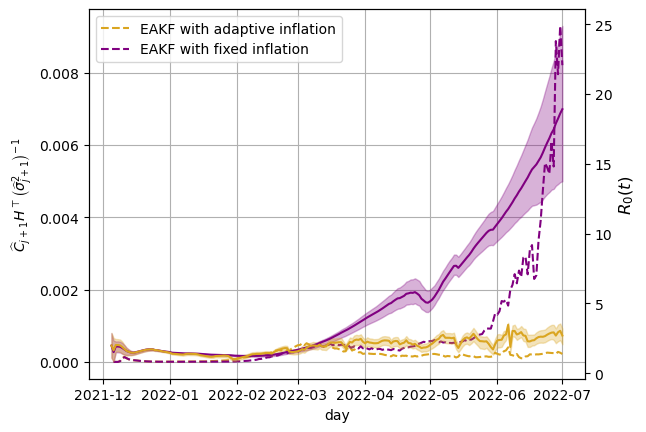

In [35]:
#fixed
i_prior = np.array([x.i for x in kf_fixed.xhat_list])
i_post = np.array([x.i for x in kf_fixed.x_list])
beta_prior = np.array([θ.beta for θ in kf_fixed.θ_list])

ols = [np.cov(i_prior[j], beta_prior[j])[0,1] / np.cov(i_prior[j], beta_prior[j])[0,0] for j in range(i_prior.shape[0])]
dx = [(i_post[j] - i_prior[j]) * ols[j] for j in range(i_prior.shape[0])]
corr = [np.corrcoef(i_prior[j], beta_prior[j])[0,1] for j in range(i_prior.shape[0])]


# adaptive
i_prior = np.array([x.i for x in kf.xhat_list])
i_post = np.array([x.i for x in kf.x_list])
beta_prior = np.array([θ.beta for θ in kf.θ_list])

adapt_ols = [np.cov(i_prior[j], beta_prior[j])[0,1] / np.cov(i_prior[j], beta_prior[j])[0,0] for j in range(i_prior.shape[0])]
adapt_corr = [np.corrcoef(i_prior[j], beta_prior[j])[0,1] for j in range(i_prior.shape[0])]

adapt_dx = [(i_post[j] - i_prior[j]) * ols[j] for j in range(i_prior.shape[0])]
      
fig, ax = plt.subplots()
      
ax.plot(df_long['Date'], adapt_ols, "--", color="goldenrod", label=r"EAKF with adaptive inflation")
ax.plot(df_long['Date'], ols, "--", color="purple", label=r"EAKF with fixed inflation")


ax2 = ax.twinx()
ax2.fill_between(df_long['Date'], ci_fixed[0,:], ci_fixed[1,:], color='purple', alpha=0.3)
ax2.plot(df_long['Date'], mean_fixed, color="purple", label=r"EAKF with fixed inflation")

ax2.fill_between(df_long['Date'], ci_adapt[0,:], ci_adapt[1,:], color='goldenrod', alpha=0.3)
ax2.plot(df_long['Date'], mean_adapt, color="goldenrod", label=r"EAKF with adaptive inflation")
ax2.set_ylabel(r'$R_0(t)$', fontsize=12)

ax.grid("dotted")
ax.set_ylabel(r"$\widehat{C}_{j+1} H^\top \left(\widehat{\sigma}_{j+1}^2\right)^{-1}$")
ax.set_xlabel("day")
ax.legend()

plt.show()

Since the prior ensemble variance in the observation variable is too small for the EAKF with fixed inflation, it more weight on the prior ensemble mean and less on the observation. The adaptive inflation is more balanced between the two.

### Plot PPD

In [38]:
np.max(kf.i_ppc)

np.float64(215165.15625860094)

/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2939563280.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2939563280.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2939563280.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/zn/k_h7_jyn53z2q5c6jyqhbsym0000gn/T/ipykernel_99592/2939563280.py:135: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using 

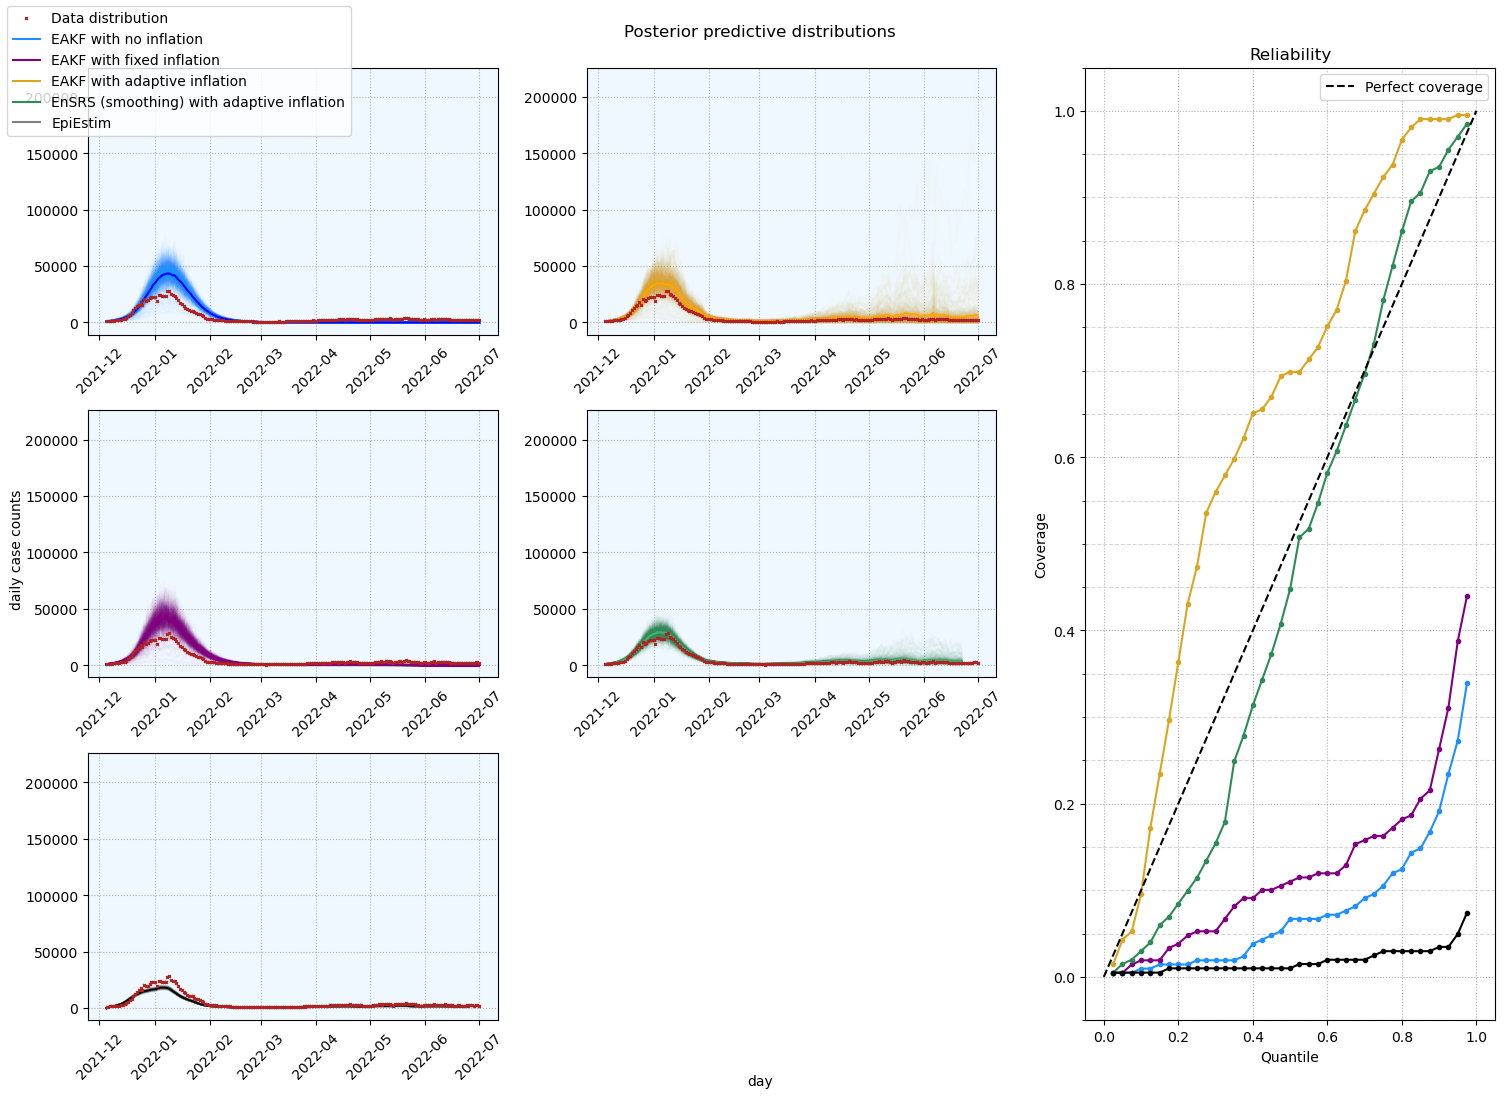

In [36]:
# # compute ppd
# kf.free_sim(np.asarray([θ.beta for θ in kf.θ_list]), add_noise=True)
# ks.free_sim(np.asarray([θ.beta for θ in ks.θ_lag_list]), add_noise=True)
# kf_none.free_sim(np.asarray([θ.beta for θ in kf_none.θ_list]), add_noise=True)
# kf_fixed.free_sim(np.asarray([θ.beta for θ in kf_fixed.θ_list]), add_noise=True)

# compute reliabilty
percentiles = np.arange(2.5, 100, 2.5)

# kf.compute_reliability(percentiles)
# ks.compute_reliability(percentiles)
# kf_none.compute_reliability(percentiles)
# kf_fixed.compute_reliability(percentiles)

plot_ppd()
plt.show()

In [37]:
# mse_none = (truth - np.mean(kf_none.i_ppc[1:], axis=1))**2
# mse_fixed = (truth - np.mean(kf_fixed.i_ppc[1:], axis=1))**2
# mse_adapt = (truth - np.mean(kf.i_ppc[1:], axis=1))**2
# mse_smooth = (truth[:-9] - np.mean(ks.i_ppc[1:], axis=1))**2

# mse_none = np.mean((truth[:, np.newaxis] - kf_none.i_ppc[1:])**2, axis=1)
# mse_fixed = np.mean((truth[:, np.newaxis] - kf_fixed.i_ppc[1:])**2, axis=1)
# mse_adapt = np.mean((truth[:, np.newaxis] - kf.i_ppc[1:])**2, axis=1)
# mse_smooth = np.mean((truth[:-9, np.newaxis] - ks.i_ppc[1:])**2, axis=1)

# fig, ax = plt.subplots()

# ax.plot(mse_none, label = 'EAKF with no inflation', color='dodgerblue')
# ax.plot(mse_fixed, label='EAKF with fixed inflation', color='purple')
# ax.plot(mse_adapt, label='EAKF with adaptive inflation', color='goldenrod')
# ax.plot(mse_smooth, label='EnSRS (smoothing) with adaptive inflation', color='seagreen')

## Try different fixed inflation values

In [38]:
# lam_list = np.arange(1, 1.5, 0.01)

# fig, axs = plt.subplots(25, 2,  figsize=(10, 50), sharex=True)

# for i, ax in enumerate(axs.flatten()):
#     lam = lam_list[i]
#     # fixed inflation
#     kf_fixed = eakf.EnsembleAdjustmentKalmanFilter(model, m=n_ens)
#     kf_fixed.oev = oev
#     kf_fixed.filter(prior, inf_method="constant", lam_fixed=lam)
#     kf_fixed.free_sim(np.asarray([θ.beta for θ in kf_fixed.θ_list]))
    
#     ax.plot(dates, kf_fixed.i_ppc[1:], color="purple", alpha=0.05)
#     ax.plot(dates, np.mean(kf_fixed.i_ppc[1:], axis=1), color='purple')
#     ax.plot(dates, truth, "x", color='firebrick', markersize=2)
#     ax.set_title(f"Fixed inflation $\lambda$={lam.round(2)}")
#     ax.grid(linestyle='dotted')
#     ax.tick_params(axis='x', labelrotation=45) 

# plt.tight_layout()

# fig.savefig('fixed_inflation_test.png')